Request for Bruce

In [4]:
import geopandas as gpd
from dem_stitcher.geojson_io import read_geojson_gzip
from tqdm import tqdm
import pandas as pd
import asf_search as asf
import datetime
import matplotlib.pyplot as plt
from shapely.geometry import box
from rasterio.crs import CRS

# Tiles

In [5]:
geo = box(-111.34, 58.674,-111.52, 58.49) 
df_aoi = gpd.GeoDataFrame(geometry=[geo], crs=CRS.from_epsg(4326))
df_aoi.explore()

In [6]:
df_mgrs = read_geojson_gzip('s2_mgrs_grid.geojson.gzip')
df_mgrs.head()

,geometry,type,identifier
0,"MULTIPOLYGON Z (((180.00000 -73.05974 0.00000,...",S2,01CCV
1,"MULTIPOLYGON Z (((180.00000 -83.80855 0.00000,...",S2,01CDH
2,"MULTIPOLYGON Z (((180.00000 -82.91344 0.00000,...",S2,01CDJ
3,"MULTIPOLYGON Z (((180.00000 -82.01866 0.00000,...",S2,01CDK
4,"MULTIPOLYGON Z (((180.00000 -81.12317 0.00000,...",S2,01CDL


In [7]:
df_mgrs_aoi = df_mgrs[df_mgrs.intersects(geo)].reset_index(drop=True)
df_mgrs_aoi

,geometry,type,identifier
0,"MULTIPOLYGON Z (((-112.72290 58.62912 0.00000,...",S2,12VVK
1,"MULTIPOLYGON Z (((-112.76847 59.52640 0.00000,...",S2,12VVL


In [8]:
TILES = df_mgrs_aoi.identifier.tolist()
TILES

['12VVK', '12VVL']

# Request

```
June 13, 2017
Sept 8, 2017
Aug 21, 2018
Sept 4, 2018
Aug 16, 2022
```

In [48]:
START_TIME = datetime.datetime(2017, 5, 1)
STOP_TIME = datetime.datetime(2022, 10, 1)

def get_df(tile: str) -> gpd.GeoDataFrame:
    geo = df_mgrs_aoi[df_mgrs_aoi.identifier == tile].geometry.tolist()[0]
    scenes = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1],
            intersectsWith=geo.wkt,
            beamMode=[asf.BEAMMODE.IW],
            processingLevel=[asf.PRODUCT_TYPE.SLC],
            start=START_TIME,
            end=STOP_TIME,
        )
    
    df = gpd.GeoDataFrame.from_features(scenes.geojson(), crs='EPSG:4326')
    df['startTime'] =  pd.to_datetime(df['startTime'])
    df['date_str'] = df['startTime'].dt.date.map(str)
    
    df_d = df.dissolve(by=['date_str', 'pathNumber'], as_index=False)

    int_geo = df_d.geometry.intersection(geo)
    perc_overlap = int_geo.area / geo.area

    admissible_dates = df_d[perc_overlap > .99].date_str.tolist()
    admissible_tracks = df_d[perc_overlap > .99].pathNumber.tolist()

    df_f = df[df.date_str.isin(admissible_dates) & df.pathNumber.isin(admissible_tracks)]
    df_f['mgrs_tile_id'] = tile
    return df_f



In [49]:
dfs = list(map(get_df, tqdm(TILES)))
df_all = pd.concat(dfs, axis=0)

  0%|                                                                              | 0/2 [00:00<?, ?it/s]/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_11051/3224341832.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  perc_overlap = int_geo.area / geo.area
/Users/cmarshak/miniforge3/envs/dswx_val/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
 50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.29s/it]/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_11

In [50]:
df_all = df_all.drop_duplicates(subset='fileID')

In [51]:
df_all.shape

(364, 27)

In [52]:
df_all['acq_dt'] = pd.to_datetime(df_all.startTime)
df_all['acq_date'] = df_all['acq_dt'].dt.date

```
June 13, 2017
Sept 8, 2017
Aug 21, 2018
Sept 4, 2018
Aug 16, 2022
```

In [53]:
ind_0 = df_all.acq_dt.dt.month.isin([5, 6,7, 9]) & df_all.acq_dt.dt.year.isin([2017])
ind_1 = df_all.acq_dt.dt.month.isin([7, 8, 9]) & df_all.acq_dt.dt.year.isin([2018])
ind_2 = df_all.acq_dt.dt.month.isin([7, 8, 9]) & df_all.acq_dt.dt.year.isin([2022])
ind = ind_0 | ind_1 | ind_2
ind.sum()

36

In [54]:
df_filtered = df_all[ind].reset_index(drop=True)
df_filtered.shape

(36, 29)

In [55]:
df_filtered['acq_dt'].dt.year.unique()

array([2018, 2017], dtype=int32)

In [56]:
df_all['acq_date'].unique().tolist()

[datetime.date(2021, 12, 20),
 datetime.date(2021, 12, 14),
 datetime.date(2021, 12, 8),
 datetime.date(2021, 12, 2),
 datetime.date(2021, 11, 26),
 datetime.date(2021, 11, 20),
 datetime.date(2021, 11, 14),
 datetime.date(2021, 11, 8),
 datetime.date(2021, 11, 2),
 datetime.date(2021, 10, 27),
 datetime.date(2021, 10, 21),
 datetime.date(2021, 10, 15),
 datetime.date(2021, 10, 9),
 datetime.date(2021, 10, 3),
 datetime.date(2021, 9, 27),
 datetime.date(2021, 9, 21),
 datetime.date(2021, 9, 15),
 datetime.date(2021, 9, 9),
 datetime.date(2021, 9, 3),
 datetime.date(2021, 8, 28),
 datetime.date(2021, 8, 22),
 datetime.date(2021, 8, 16),
 datetime.date(2021, 8, 10),
 datetime.date(2021, 8, 4),
 datetime.date(2021, 7, 29),
 datetime.date(2021, 7, 23),
 datetime.date(2021, 7, 17),
 datetime.date(2021, 7, 11),
 datetime.date(2021, 7, 5),
 datetime.date(2021, 6, 29),
 datetime.date(2021, 6, 23),
 datetime.date(2021, 6, 17),
 datetime.date(2021, 6, 11),
 datetime.date(2021, 6, 5),
 datetime.d

In [57]:
df_filtered.to_csv('bc_bruce_request.csv')

In [58]:
df_filtered.pathNumber.unique()

array([71])

<Axes: >

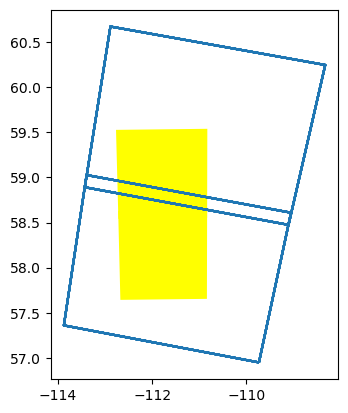

In [59]:
fig, ax = plt.subplots()
df_filtered.exterior.plot(ax=ax)
df_mgrs_aoi.plot(ax=ax, color='yellow')